# VQO of Mutual Information in Finger Printing MAC Game

Consider a two sender multiple access channel assisted by entanglement shared between the two senders.
Given their local input $x_i\in\{0,1,2\}$, each sender measures their side of the entangled state and sends (classically) the result to a MAC Game that referees a finger printing task between the two senders.
The two senders win this game if their respective inputs, $x_1$ and $x_2$, match.
The challenge is, however, that the two senders do not communicate and may only send 1-bit to the receiving MAC.
That is, the complete input cannot be sent.

In [1]:
from qnet_context import QNetOptimizer as QNopt
from mac_context import *
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

## Ansatz

In [2]:
ea_prep_node = [
    QNopt.PrepareNode(1, [0,1], QNopt.ghz_state, 0)
]
cl_prep_node = [
    QNopt.PrepareNode(1, [0,1], lambda settings, wires: None, 0)
]
ry_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(3, 2, [1], QNopt.local_RY, 1)
]

ea_ansatz = QNopt.NetworkAnsatz(ea_prep_node, ry_meas_nodes)
cl_ansatz = QNopt.NetworkAnsatz(cl_prep_node, ry_meas_nodes)

# uniform prior distribution
uniform3 = np.ones(3)/3

## MAC Game Behaviors

The Game behaviors are defined similarly to [Playing Games with MACs](https://arxiv.org/abs/1909.02479) (see Eq. 2).


In [3]:
def mac_game_behavior_fn(ansatz):
    """Constructs and ansatz-specific behavior function.
    
    The the function is called as `behavior(ansatz_settings, [prior_x1, prior_x2])`
    with `prior_x1` and `prior_x2` being prior distibutions P(x1) and P(x2).
    
    The constructed behavior has form P(z|x1,x2,y1,y2) with a joint prior distribution
    P(x1,x2,y1,y2) = P(x1)P(x2)P(y1,y2|x1,x2).
    """
        
    fp_behavior = QNopt.behavior_fn(ansatz)
    
    def behavior_fn(settings, priors):
        
        raw_behavior = fp_behavior(settings)
        
        prior_xy = np.kron(priors[0], priors[1])
        
        new_priors = (raw_behavior * prior_xy).T.reshape(36) 
                
        P_win = []
        P_mac_game = np.zeros((9,36))
        i = 0
        for x in range(3):
            for y in range(3):
                
                win_col_ids = [0,3] if x == y else [1,2]
                lose_col_ids = [1,2] if x == y else [0,3]
                
                block_xy = np.zeros((9,4)) 
                block_xy[3*x + y, win_col_ids] = [1,1]
                block_xy[:,lose_col_ids] = np.ones((9,2))/9
                
                P_mac_game[:,4*i:4*(i + 1)] = block_xy
                
                i += 1
                
        return P_mac_game, new_priors
    
    return behavior_fn

def big_mac_game_behavior_fn(ansatz):
    """Constructs and ansatz-specific behavior function.
    
    The the function is called as `behavior(ansatz_settings)`.
    
    The constructed behavior has form P(z|x1,x2)..
    """
        
    fp_behavior = QNopt.behavior_fn(ansatz, post_map=np.array([[1,0,0,1],[0,1,1,0]]))
    fp_mat = np.array([[1,0,0,0,1,0,0,0,1],[0,1,1,1,0,1,1,1,0]])
    
    def behavior_fn(settings):
        
        raw_behavior = fp_behavior(settings)    
               
        P_win = []
        for x in range(3):
            for y in range(3):    
                row_id = 0 if x == y else 1
                P_win.append(raw_behavior[row_id, 3*x + y])         
                
        behavior = np.diag(P_win)
                
        for i in range(len(P_win)):
            P_lose = 1 - P_win[i]
            behavior[:,i] += P_lose * np.ones(9)/9
                                    
        return behavior       
    
    return behavior_fn

## MAC Game Rate Tuple

$$
\Big\{R_1 \leq I(Z;X_1,Y_1|X_2,Y_2),\quad R_2 \leq I(Z;X_2,Y_2|X_1,Y_1),\quad R_1 + R_2 \leq I(Z;X_1,X_2,Y_1,Y_2)\Big\}
$$

In [4]:
def mac_game_rate_tuple(behavior, priors):
    """Evaluates the rate tuple (R1, R2, R1 + R2) for a given mac game
    behavior matrix with probabilities P(z|x1,x2,y1,y2) and priors P(x1,x2,y1,y2).
        
    Returns the rate tuple (R1, R2, R_sum) 
    """
    P_x1x2y1y2 = behavior * priors
    
    P_x1x2y1 = P_x1x2y1y2[:,0:36:2] + P_x1x2y1y2[:,1:36:2]
    priors_x1x2y1 = priors[0:36:2] + priors[1:36:2]
    
    y1_ids = np.array([0,1,4,5,8,9,12,13,16,17,20,21,24,25,28,29,32,33])
    P_x1x2y2 = P_x1x2y1y2[:, y1_ids] + P_x1x2y1y2[:,y1_ids+2]
    priors_x1x2y2 = priors[y1_ids] + priors[y1_ids+2]
    
    x2_ids = np.array([0,1,6,7,12,13])
    P_x1y1 = P_x1x2y1[:,x2_ids] + P_x1x2y1[:,x2_ids + 2] + P_x1x2y1[:,x2_ids + 4]
    priors_x1y1 = priors_x1x2y1[x2_ids] + priors_x1x2y1[x2_ids + 2] + priors_x1x2y1[x2_ids + 4]
    
    x1_ids = np.array([0,1,2,3,4,5])
    P_x2y2 = P_x1x2y2[:,x1_ids] + P_x1x2y2[:,x1_ids + 6] + P_x1x2y2[:,x1_ids + 12]
    priors_x2y2 = priors_x1x2y2[x1_ids] + priors_x1x2y2[x1_ids + 6] + priors_x1x2y2[x1_ids + 12]
    
    H_in = QNopt.shannon_entropy(priors)
    H_joint = QNopt.shannon_entropy((P_x1x2y1y2).T.reshape(9*36))
    H_z = QNopt.shannon_entropy([np.sum(row) for row in (P_x1x2y1y2)])

    mutual_info = H_in + H_z - H_joint
    
    H_x1y1 = QNopt.shannon_entropy(priors_x1y1)
    H_x2y2 = QNopt.shannon_entropy(priors_x2y2)
    H_zx1y1 = QNopt.shannon_entropy((P_x1y1).T.reshape(9*6))
    H_zx2y2 = QNopt.shannon_entropy((P_x2y2).T.reshape(9*6))
    
    mutual_info_z_x1y1 = H_z + H_x1y1 - H_zx1y1
    mutual_info_z_x2y2 = H_z + H_x2y2 - H_zx2y2
        
    return (mutual_info - mutual_info_z_x2y2, mutual_info - mutual_info_z_x1y1 , mutual_info)

## Ideal Entanglement Assisted Rate Region for Uniform Priors

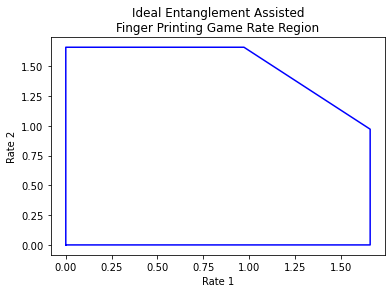

In [6]:
ea_mac_behavior = mac_game_behavior_fn(ea_ansatz)

ideal_settings = [
    [np.array([[]])],
    [np.array([[0],[2*np.pi/3],[4*np.pi/3]]), np.array([[0],[2*np.pi/3],[4*np.pi/3]])]
]

priors = [uniform3, uniform3]
P_ea_ideal, ideal_priors = ea_mac_behavior(ideal_settings, priors)

ideal_ea_rate_tuple = mac_game_rate_tuple(P_ea_ideal, ideal_priors)

r1_vals, r2_vals = rate_region_vertices(ideal_ea_rate_tuple)
    
plt.plot(r1_vals, r2_vals,"b-")
plt.title("Ideal Entanglement Assisted\nFinger Printing Game Rate Region")
plt.xlabel("Rate 1")
plt.ylabel("Rate 2")
plt.show()

## Perfect Winning Finger Printing Rate Region

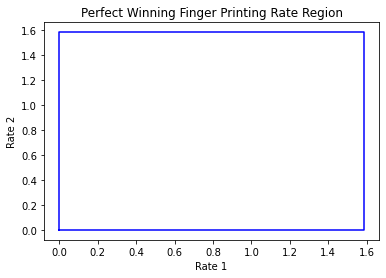

In [7]:
# perfect MAC Strategy for finger printing
P_perfect_mac = np.array([
    [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1],
])
perfect_priors = np.array(
    [1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1]
)/18

perfect_rate_tuple = mac_game_rate_tuple(P_perfect_mac, perfect_priors)

r1_vals, r2_vals = rate_region_vertices(perfect_rate_tuple)
    
plt.plot(r1_vals, r2_vals,"b-")
plt.title("Perfect Winning Finger Printing Rate Region")
plt.xlabel("Rate 1")
plt.ylabel("Rate 2")
plt.show()

## Cost Function for Optimal Sum Rate

In [8]:
def mutual_info_finger_printing_cost_fn(ansatz, priors):
    
    probs_qnode = QNopt.joint_probs_qnode(ansatz)
    
    def cost_fn(ansatz_settings):
        # optimize winning probability
        P_Z_list = []
        for x in range(3):
            for y in range(3):
                
                settings = ansatz.qnode_settings(ansatz_settings, [0], [x, y]) # prep node is static
                probs_xy = probs_qnode(settings)
                                
                prior = priors[0][x] * priors[1][y]   
                win_ids = [0,3] if x == y else [1,2]
                
                P_win_xy = np.sum(probs_xy[win_ids]) * prior
                             
                P_Z_list.append(P_win_xy)
        
        # postprocess winning probablity into mutual information
        P_lose = 1 - np.sum(P_Z_list)
        
        P_Z = P_lose * np.ones(9)/9 + np.array(P_Z_list)
                
        H_Z = QNopt.shannon_entropy(P_Z)
                
        mutual_info = H_Z - P_lose * np.log2(9)
                        
        return -(mutual_info)
    
    return cost_fn


def scan_fp_rate_region(ansatz, prior_x1_samples, prior_x2_samples, **opt_kwargs):
    
    rate_tuples = []
    opt_dicts = []
    priors_list = []
    for prior_x1 in prior_x1_samples:
        for prior_x2 in prior_x2_samples:
            print("prior_x1  = ", prior_x1)
            print("prior_x2 = ", prior_x2)
            
            cost = mutual_info_finger_printing_cost_fn(ansatz, [prior_x1, prior_x2])

            opt_dict = QNopt.gradient_descent(
                cost,
                ansatz.rand_scenario_settings(),
                **opt_kwargs
            )
            
            mac_behavior = mac_game_behavior_fn(ansatz)
                   
            P_mac, prior_mac = mac_behavior(
                opt_dict["opt_settings"],
                [prior_x1, prior_x2]
            )
            rate_tuple = mac_game_rate_tuple(P_mac, prior_mac)
            print(rate_tuple)
        
            opt_dicts.append(opt_dict)
            rate_tuples.append(rate_tuple)
            priors_list.append([prior_x1, prior_x2])
                  
    return rate_tuples, opt_dicts, priors_list

## Entanglement-Assisted Data Collection

In [9]:
ea_rate_tuples = []
ea_opt_dicts = []
ea_priors_list = []

### EA: Uniform Priors

In [10]:
opt_score = 0
while opt_score < 2.6:
    ea_rate_tuples_uni, ea_opt_dicts_uni, ea_priors_list_uni = scan_fp_rate_region(
        ea_ansatz,
        [uniform3],
        [uniform3],
        num_steps=50,
        step_size=0.5,
        sample_width=5,
        verbose=False
    )
    
    opt_score = ea_opt_dicts_uni[0]["opt_score"]
    print(opt_score)
    

ea_rate_tuples.extend(ea_rate_tuples_uni)
ea_opt_dicts.extend(ea_opt_dicts_uni)
ea_priors_list.extend(ea_priors_list_uni)  

prior_x1  =  [0.33333333 0.33333333 0.33333333]
prior_x2 =  [0.33333333 0.33333333 0.33333333]
(1.503620166103838, 1.503619444410468, 2.3498213650728967)
2.3498213650728967
prior_x1  =  [0.33333333 0.33333333 0.33333333]
prior_x2 =  [0.33333333 0.33333333 0.33333333]
(1.6600468193795201, 1.6600468194737559, 2.6318315353432755)
2.6318315353432764


### EA: Prior Scan Step = 1/3 

In [11]:
%%time

scan_range3 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(3)
], axis=0)

ea_rate_tuples3, ea_opt_dicts3, ea_priors_list3 = scan_fp_rate_region(
    ea_ansatz,
    scan_range3,
    scan_range3,
    num_steps=50,
    step_size=0.5,
    sample_width=5,
    verbose=False
)

ea_rate_tuples.extend(ea_rate_tuples3)
ea_opt_dicts.extend(ea_opt_dicts3)
ea_priors_list.extend(ea_priors_list3)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
(0.7445137576865402, 0.7445137576865402, 0.7445137576865406)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.333 0.667]
(0.49469050769435396, 1.2629169985642248, 1.2629169985642248)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.333 0.333 0.333]
(0.3848393483526875, 1.6860353456525328, 1.6874773191053314)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0. 0. 1.]
(1.2631493508083098, 0.4908025543710419, 1.2631493508083098)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.    0.333 0.667]
(1.1299234316786975, 1.1303816857842177, 1.9143566614013858)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.333 0.333 0.333]
(1.1180550534103046, 1.6759436939310492, 2.3233563888823108)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0. 0. 1.]
(1.6844707265735828, 0.36038962273321307, 1.6859127000263827)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.    0.333 0.667]
(1.6760463785512512, 1.1184260667379684, 2.323357755641073)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  

### EA: Prior Scan Step = 1/4

In [12]:
%%time

scan_range4 = np.unique([np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(4)], axis=0)

ea_rate_tuples4, ea_opt_dicts4, ea_priors_list4 = scan_fp_rate_region(
    ea_ansatz,
    scan_range4,
    scan_range4,
    num_steps=50,
    step_size=0.5,
    sample_width=5,
    verbose=False
)

ea_rate_tuples.extend(ea_rate_tuples4)
ea_opt_dicts.extend(ea_opt_dicts4)
ea_priors_list.extend(ea_priors_list4)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
(0.7445137576865397, 0.7445137576865397, 0.7445137576865406)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.   0.25 0.75]
(0.5492348240136069, 1.2170029993910458, 1.2170029993910463)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.  0.5 0.5]
(0.6034772215263127, 1.2721044722054393, 1.2721044722054389)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.25 0.25 0.5 ]
(0.3391105182620011, 1.6631698153427097, 1.6631698153427097)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0. 0. 1.]
(1.216953599169143, 0.5495604091329525, 1.216953599169143)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.   0.25 0.75]
(1.09873257900187, 1.101401853268396, 1.7506529430950653)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.  0.5 0.5]
(1.0643945229427327, 1.1731924828796756, 1.8853719079519244)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.25 0.25 0.5 ]
(1.0103202644218823, 1.5910296018471608, 2.1826482504166087)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0. 0. 1.]
(1.2721182618398217, 0.60348273667264

## Classical Data Collection

In [13]:
cl_rate_tuples = []
cl_opt_dicts = []
cl_priors_list = []

## CL: Uniform Priors

In [14]:
%%time

opt_score = 0
while opt_score < 2.29:
    cl_rate_tuples_uni, cl_opt_dicts_uni, cl_priors_list_uni = scan_fp_rate_region(
        cl_ansatz,
        [uniform3],
        [uniform3],
        num_steps=50,
        step_size=0.5,
        sample_width=5,
        verbose=False
    )
    
    opt_score = cl_opt_dicts_uni[0]["opt_score"]
    print(opt_score)

cl_rate_tuples.extend(cl_rate_tuples_uni)
cl_opt_dicts.extend(cl_opt_dicts_uni)
cl_priors_list.extend(cl_priors_list_uni)

prior_x1  =  [0.33333333 0.33333333 0.33333333]
prior_x2 =  [0.33333333 0.33333333 0.33333333]
(1.3561298451238701, 1.3852945039578737, 2.2947318525278195)
2.294731852527818
CPU times: user 2.09 s, sys: 16.6 ms, total: 2.11 s
Wall time: 2.11 s


## CL: Priorrs Scan = 1/3

In [15]:
%%time

scan_range3 = np.unique([
    np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(3)
], axis=0)

cl_rate_tuples3, cl_opt_dicts3, cl_priors_list3 = scan_fp_rate_region(
    cl_ansatz,
    scan_range3,
    scan_range3,
    num_steps=50,
    step_size=0.5,
    sample_width=5,
    verbose=False
)

cl_rate_tuples.extend(cl_rate_tuples3)
cl_opt_dicts.extend(cl_opt_dicts3)
cl_priors_list.extend(cl_priors_list3)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
(0.34527791325257207, 0.7414635702697217, 0.7445137576865406)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.    0.333 0.667]
(0.5928065621288452, 0.8606246736164582, 1.1974390555960284)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.333 0.333 0.333]
(0.16286983275733036, 1.6295233961376487, 1.6834952527904714)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0. 0. 1.]
(1.2309610173156589, 0.1858722898574361, 1.2583434498065578)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.    0.333 0.667]
(1.1338630225317612, 0.8568192415035156, 1.9002176832893918)
prior_x1  =  [0.    0.333 0.667]
prior_x2 =  [0.333 0.333 0.333]
(0.8807338648473544, 1.5690161944335332, 2.2073336271903266)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0. 0. 1.]
(1.6409234137116897, 0.1447027644799097, 1.685670549214466)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  [0.    0.333 0.667]
(1.4481252363232207, 0.9617331906189404, 2.1832530635900884)
prior_x1  =  [0.333 0.333 0.333]
prior_x2 =  

## CL: Priors Scan Step = 1/4

In [16]:
%%time

scan_range4 = np.unique([np.around(np.sort(prior),decimals=3) for prior in priors_scan_range(4)], axis=0)

cl_rate_tuples4, cl_opt_dicts4, cl_priors_list4 = scan_fp_rate_region(
    cl_ansatz,
    scan_range4,
    scan_range4,
    num_steps=50,
    step_size=0.5,
    sample_width=5,
    verbose=False
)

cl_rate_tuples.extend(cl_rate_tuples4)
cl_opt_dicts.extend(cl_opt_dicts4)
cl_priors_list.extend(cl_priors_list4)

prior_x1  =  [0. 0. 1.]
prior_x2 =  [0. 0. 1.]
(0.19035130334961892, 0.7433837393615468, 0.7445137576865402)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.   0.25 0.75]
(0.02235415468698232, 1.2149286491710751, 1.216334184985079)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.  0.5 0.5]
(0.44670462972518354, 1.1090000746722426, 1.270055021931162)
prior_x1  =  [0. 0. 1.]
prior_x2 =  [0.25 0.25 0.5 ]
(0.17996858641204083, 1.60155693917714, 1.6493798726219642)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0. 0. 1.]
(1.2055361923602077, 0.09275224030919471, 1.2133167989601055)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.   0.25 0.75]
(0.8463472002755084, 1.0522540962251847, 1.722744186048366)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.  0.5 0.5]
(1.0517489781072031, 0.9444859438133699, 1.8838010882573224)
prior_x1  =  [0.   0.25 0.75]
prior_x2 =  [0.25 0.25 0.5 ]
(0.7681415902536033, 1.505193591552592, 2.117247507189271)
prior_x1  =  [0.  0.5 0.5]
prior_x2 =  [0. 0. 1.]
(1.2020029973291653, 0.30383464739

## Plotting Rate Region Inner Bounds

To evaluate a inner bound on the rate region, we apply similar methods to https://ieeexplore.ieee.org/abstract/document/5590317.

We have collected optimized rate regions for a wide range of priors, it remains to take their convex hull and trace out their boundary. This is done with a (linear approximation?) method outlined in the above article.

In [17]:
def rate_region_inner_bound(rate_tuples, priors, theta_scan=np.arange(0,1.001,0.01)):
    
    R1_vals = []
    R2_vals = []
    opt_rate_tuples = []
    opt_priors = []

    for theta in theta_scan:

        theta_sum_rates = []
        R1_scores = []
        R2_scores = []
        for r_tuple in rate_tuples:
            biased_rate = theta*r_tuple[0] + (1-theta)*r_tuple[1]
            R1 = r_tuple[0]
            R2 = r_tuple[1]

            if r_tuple[0] + r_tuple[1] > r_tuple[2]:
                if theta*r_tuple[0] + (1-theta)*(r_tuple[2]-r_tuple[0]) >= theta*(r_tuple[2]-r_tuple[1]) + (1-theta)*r_tuple[1]:
                    biased_rate = theta*r_tuple[0] + (1-theta)*(r_tuple[2]-r_tuple[0])
                    R2 = r_tuple[2]-r_tuple[0]
                else:
                    biased_rate = theta*(r_tuple[2]-r_tuple[1]) + (1-theta)*r_tuple[1]
                    R1 = r_tuple[2]-r_tuple[1]

            theta_sum_rates.append(biased_rate)
            R1_scores.append(R1)
            R2_scores.append(R2)

        max_theta_sum_rate = max(theta_sum_rates)
        max_id = theta_sum_rates.index(max_theta_sum_rate)

        opt_rate_tuples.append(rate_tuples[max_id]) 
        opt_priors.append(priors[max_id])
        R1_vals.append(R1_scores[max_id])
        R2_vals.append(R2_scores[max_id])
        
    return R1_vals, R2_vals, opt_rate_tuples, opt_priors

In [18]:
%%time

ea_R1_vals, ea_R2_vals, ea_opt_rate_tuples, ea_opt_priors = rate_region_inner_bound(
    ea_rate_tuples, ea_priors_list, theta_scan=np.arange(0,1.001,0.001)
)
cl_R1_vals, cl_R2_vals, cl_opt_rate_tuples, cl_opt_priors = rate_region_inner_bound(
    cl_rate_tuples, ea_priors_list, theta_scan=np.arange(0,1.001,0.001)
)

CPU times: user 15 s, sys: 30 ms, total: 15.1 s
Wall time: 15.1 s


EA: extremal rate tuple :  [0.38483935 1.68603535 1.68747732]
EA: prior_x1 :  [0.0, 0.0, 1.0]
EA: prior_x2 :  [0.333, 0.333, 0.333]
EA: extremal rate tuple :  [1.11805505 1.67594369 2.32335639]
EA: prior_x1 :  [0.0, 0.333, 0.667]
EA: prior_x2 :  [0.333, 0.333, 0.333]
EA: extremal rate tuple :  [1.66004682 1.66004682 2.63183154]
EA: prior_x1 :  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
EA: prior_x2 :  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
EA: extremal rate tuple :  [1.67604638 1.11842607 2.32335776]
EA: prior_x1 :  [0.333, 0.333, 0.333]
EA: prior_x2 :  [0.0, 0.333, 0.667]
EA: extremal rate tuple :  [1.68447073 0.36038962 1.6859127 ]
EA: prior_x1 :  [0.333, 0.333, 0.333]
EA: prior_x2 :  [0.0, 0.0, 1.0]
CL: extremal rate tuple :  [0.16286983 1.6295234  1.68349525]
CL: prior_x1 :  [0.0, 0.0, 1.0]
CL: prior_x2 :  [0.333, 0.333, 0.333]
CL: extremal rate tuple :  [0.88073386 1.56901619 2.20733363]
CL: prior_x1 :  [0.0, 0.333, 0.667]
CL: prior_x2 :  [0

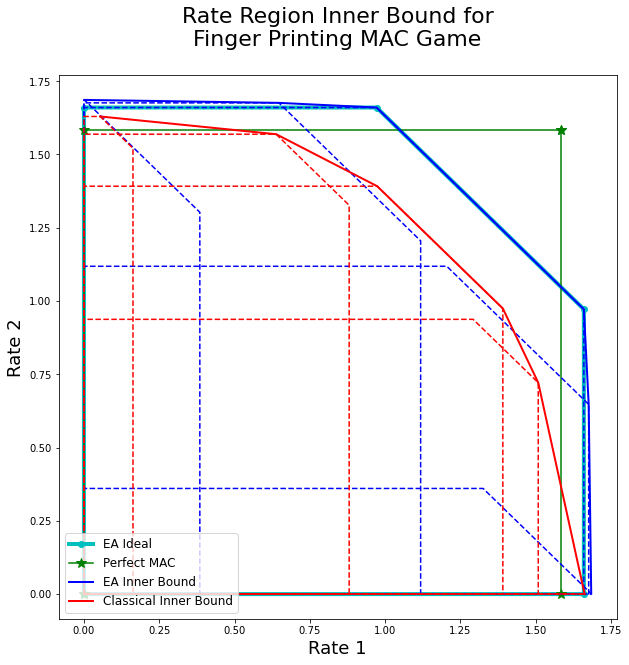

In [19]:
%%time

plt.figure(figsize=(10,10))

# ideal ea rate region uniform priors
r1_vals, r2_vals = rate_region_vertices(ideal_ea_rate_tuple)  
plt.plot(r1_vals, r2_vals,"c.-",linewidth=4, markersize=12, label="EA Ideal")

# perfect rate region uniform priors
r1_vals, r2_vals = rate_region_vertices(perfect_rate_tuple)
plt.plot(r1_vals, r2_vals,"g*-",label="Perfect MAC", markersize=10)


ea_unique_rate_tuples = np.unique(ea_opt_rate_tuples, axis=0)
for r_tuple in ea_unique_rate_tuples:
    
    print("EA: extremal rate tuple : ", r_tuple)
    tuple_id = ea_rate_tuples.index(tuple(r_tuple))
    priors = ea_priors_list[tuple_id]
    
    print("EA: prior_x1 : ", priors[0].tolist())
    print("EA: prior_x2 : ", priors[1].tolist())
    
    r1_vals, r2_vals = rate_region_vertices(r_tuple)  
    plt.plot(r1_vals, r2_vals,"b--")

plt.plot(ea_R1_vals, ea_R2_vals, "b-", linewidth=2, label="EA Inner Bound")
     
cl_unique_rate_tuples = np.unique(cl_opt_rate_tuples, axis=0)
for r_tuple in cl_unique_rate_tuples:
    
    print("CL: extremal rate tuple : ", r_tuple)
    tuple_id = cl_rate_tuples.index(tuple(r_tuple))
    priors = cl_priors_list[tuple_id]
    
    print("CL: prior_x1 : ", priors[0].tolist())
    print("CL: prior_x2 : ", priors[1].tolist())
    
    r1_vals, r2_vals = rate_region_vertices(r_tuple)  
    plt.plot(r1_vals, r2_vals,"r--")

plt.plot(cl_R1_vals, cl_R2_vals, "r-", linewidth=2, label="Classical Inner Bound")
plt.xlabel("Rate 1", size=18)
plt.ylabel("Rate 2", size=18)
plt.title("Rate Region Inner Bound for\nFinger Printing MAC Game\n", size=22)


plt.legend(loc="lower left", fontsize=12)